In [72]:
!pip install pgeocode
!pip install xarray
!pip install h5netcdf
!pip install cartopy
!pip install matplotlib


[notice] A new release of pip available: 22.3 -> 24.1.2
[notice] To update, run: pip3 install --upgrade pip
Reshimming asdf python...

[notice] A new release of pip available: 22.3 -> 24.1.2
[notice] To update, run: pip3 install --upgrade pip
Reshimming asdf python...

[notice] A new release of pip available: 22.3 -> 24.1.2
[notice] To update, run: pip3 install --upgrade pip
Reshimming asdf python...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 72.3 kB/s eta 0:00:00m eta 0:00:010:00:05
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 59.6 kB/s eta 0:00:00m eta 0:00:010:00:04m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 130.9 kB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 207.6 kB/s eta 0:00:001m241.2 kB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 56.9 kB/s eta 0:00:00m eta 0:00:010:00:03m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.9/245.9 kB 69.8 kB/s eta 0:00:00m eta 0:0

In [2]:
import pgeocode
nomi = pgeocode.Nominatim('us') 

import pandas as pd
import numpy as np
import xarray as xr

In [3]:
postal_code = nomi.query_postal_code("33483")

In [4]:
zip_codes = pd.DataFrame({'ZIP': ['33483'], 
                         'latitude': [postal_code['latitude']],
                         'longitude': [postal_code['longitude']]})

In [5]:
print(zip_codes)

     ZIP  latitude  longitude
0  33483   26.4546   -80.0656


In [6]:
# Replace 'your_loca_tasmin_file.nc' and 'your_loca_tasmax_file.nc' with your actual file paths
loca_tasmin_file = 'tasmin.MPI-ESM1-2-HR.ssp245.r1i1p1f1.2015-2044.LOCA_16thdeg_v20220413.s_east.nc'
loca_tasmax_file = 'tasmax.MPI-ESM1-2-HR.ssp245.r1i1p1f1.2015-2044.LOCA_16thdeg_v20220413.s_east.nc'

# Open the NetCDF files using xarray
ds_tasmin = xr.open_dataset(loca_tasmin_file)
ds_tasmax = xr.open_dataset(loca_tasmax_file)

# Extract the 'tasmin' and 'tasmax' variables
loca_tasmin = ds_tasmin['tasmin']
loca_tasmax = ds_tasmax['tasmax']

# Optionally, select a subset of the data if needed
# (e.g., by time period or geographic region)
loca_tasmin = loca_tasmin.sel(time=slice('2022-01-01', '2024-01-01'), lat=slice(26, 28), lon=slice(360-81, 360-80))
loca_tasmax = loca_tasmax.sel(time=slice('2022-01-01', '2024-01-01'), lat=slice(26, 28), lon=slice(360-81, 360-80))

In [7]:
print(loca_tasmin)

<xarray.DataArray 'tasmin' (time: 731, lat: 32, lon: 16)> Size: 1MB
[374272 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 128B 279.0 279.1 279.2 279.2 ... 279.8 279.9 280.0
  * lat      (lat) float64 256B 26.03 26.09 26.16 26.22 ... 27.84 27.91 27.97
  * time     (time) datetime64[ns] 6kB 2022-01-01T12:00:00 ... 2024-01-01T12:...
Attributes:
    units:    K
    history:   pierce 2023-08-14 09:28:45.882494 /net/mead24/data/LOCA2_CONUS...
    region::  s_east


In [81]:
# Replace 'your_ecocrop_file.csv' with your actual file path
ecocrop_file = 'EcoCrop_DB.csv'

# Read the CSV file into a Pandas DataFrame
ecocrop_df = pd.read_csv(ecocrop_file, encoding='latin-1')

# Select your crop of interest (replace 'Maize' with your desired crop)
crop_name = 'Allium cepa'
# crop_name = "Vigna unguiculata"
crop = ecocrop_df[ecocrop_df['ScientificName'] == crop_name]

# Extract the relevant parameters (adjust column names if needed)
tmin = crop['TMIN'].values[0]
tmax = crop['TMAX'].values[0]
topt_min = crop['TOPMN'].values[0]
topt_max = crop['TOPMX'].values[0]
gmin = crop['GMIN'].values[0]
gmax = crop['GMAX'].values[0]

In [9]:
def find_nearest_grid_point(lat, lon):
    if lat < 0:
        lat = 360 + lat
    if lon < 0:
        lon = 360 + lon
    distances = np.sqrt((loca_tasmin['lat'] - lat)**2 + (loca_tasmin['lon'] - lon)**2)

    return np.unravel_index(distances.argmin(), distances.shape)  # Returns the index of the closest grid point


In [69]:
zip_codes['loca_index'] = zip_codes.apply(
    lambda row: find_nearest_grid_point(row['latitude'], row['longitude']),
    axis=1
)

In [70]:
print(zip_codes['loca_index'].values)

[(7, 14)]


In [82]:
lat, lon = zip_codes['loca_index'].values[0]
zip_codes_tasmin = loca_tasmin.isel(
    lat=lat,
    lon=lon,
)
# print(foo.sel(time="2023-01-02").values)
zip_codes['average_tasmin'] = zip_codes_tasmin.mean(dim='time')

In [13]:
# import cartopy.crs as ccrs
# import matplotlib.pyplot as plt

# # Get latitude and longitude coordinates of the nearest grid points
# lat, lon = zip_codes['loca_index'].values[0]
# zip_codes['lat'] = loca_tasmin['lat'].isel(lat=lat)
# zip_codes['lon'] = loca_tasmin['lon'].isel(lon=lon)

# # Create a map
# plt.figure(figsize=(10, 6))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.coastlines()

# # Plot the average tasmin for each ZIP code (example)
# plt.scatter(zip_codes['lon'], zip_codes['lat'], c=zip_codes['average_tasmin'], cmap='coolwarm', transform=ccrs.PlateCarree())
# plt.colorbar(label='Average Tasmin (°C)')
# plt.title('Average Minimum Temperature by ZIP Code')
# plt.show()

In [156]:
# Function to calculate daily suitability based on temperature
# def calculate_suitability(tasmin, tasmax, tmin, tmax, topt_min, topt_max):
#     # Check if temperature is within acceptable range
#     tmin = tmin + 273.15
#     tmax = tmax + 273.15
#     topt_min = topt_min + 273.15
#     topt_max = topt_max + 273.15
#     within_range = (tasmin <= tmin) & (tasmax >= tmax)

#     # Calculate suitability within the optimum range
#     suitability_top = np.minimum(1, (tasmax - topt_min) / (topt_max - topt_min))

#     # Calculate suitability below the optimum range
#     suitability_bottom = np.minimum(1, (topt_min - tasmin) / (topt_min - tmin))

#     # Combine the suitability scores
#     suitability = np.where(
#         within_range, 
#         np.maximum(suitability_top, suitability_bottom),  # Take the higher suitability in the optimum range
#         0  # Unsuitable outside the range
#     )

#     return suitability


In [72]:
def calculate_suitability(tasmin, tasmax, tmin, tmax, topt_min, topt_max, frost_tolerance):
    tmin = tmin + 273.15
    tmax = tmax + 273.15
    topt_min = topt_min + 273.15
    topt_max = topt_max + 273.15
    # Basic suitability based on absolute thresholds
    suitability = ((tasmin > (tmin - frost_tolerance)) & (tasmax < tmax)).astype(float)  

    # Further refinement based on optimal temperature range
    optimal_range = ((topt_min < tasmin) & (tasmin < topt_max) & (topt_min < tasmax) & (tasmax < topt_max))

    # Linear interpolation between thresholds
    suitability = xr.where(optimal_range, 1.0, suitability)  # Optimal range has perfect suitability (1.0)
    suitability = xr.where(
        tasmin < topt_min,
        (tasmin - tmin) / (topt_min - tmin),  # Linear interpolation for values below optimal range
        suitability
    )
    suitability = xr.where(
        tasmax > topt_max,
        (tmax - tasmax) / (tmax - topt_max),  # Linear interpolation for values above optimal range
        suitability
    )

    # Ensure suitability is within 0-1 range
    suitability = suitability.clip(0, 1)

    return suitability

In [150]:
# loca_tas = (loca_tasmin + loca_tasmax) / 2

In [121]:
# Calculate daily suitability for the entire LOCA dataset using apply_ufunc
frost_tolerance = 0
daily_suitability = xr.apply_ufunc(
    calculate_suitability,
    loca_tasmin, loca_tasmax, tmin, tmax, topt_min, topt_max, frost_tolerance,
    input_core_dims=[["time"], ["time"], [], [], [], [], []],  # Specify that these are scalars
    output_core_dims=[["time"]],  # Output is a single value per input
    vectorize=True,  # Optimize for speed
    dask='parallelized'  # Use Dask for parallel computation (if available)
)

In [110]:
# print(daily_suitability.isel(lat=lat, lon=lon))

In [116]:
import pandas as pd
import xarray as xr
import datetime

# ... (Your existing code to calculate daily_suitability)

# Aggregate suitability over growing season (window size = GMIN to GMAX)
growing_season_suitability = {}
for window_size in range(int(gmin), int(gmax) + 1, 10):
    # Extend the data for circular rolling
    # season_suitability = daily_suitability.rolling(time=window_size, min_periods=window_size, center=False).mean()
    season_suitability = daily_suitability[::-1].rolling(time=window_size, min_periods=window_size, center=True).mean()[::-1]

    # Slice out the original data's suitability after the circular rolling
    growing_season_suitability[window_size] = season_suitability

def chunk_contiguous_dates(dates):
    """Chunks a pandas Series of dates into contiguous sections.

    Args:
        dates (pd.Series): A pandas Series of datetime values.

    Returns:
        list: A list of lists, where each inner list represents a contiguous section of dates.
    """
    # Calculate differences between consecutive dates
    diffs = dates.diff()

    # Identify boundaries where the difference is not 1 day (indicating a break in the sequence)
    boundaries = diffs.ne(pd.to_timedelta("1 days")).cumsum() 

    # Group dates by boundaries and convert each group to a list
    contiguous_sections = dates.groupby(boundaries).apply(list).tolist()

    return contiguous_sections


# Find optimal planting date RANGES for each growing season length
optimal_planting_ranges = {}
for window_size, suitability in growing_season_suitability.items():
    # Get all suitable dates (above threshold)
    suitability = suitability.isel(lat=lat,lon=lon)
    # print(suitability.time)
    suitable_dates = suitability.where(suitability > 0.4).dropna(dim='time')
    # print(suitability.isel(lat=lat,lon=lon).dropna(dim="time"))
    # Group consecutive dates into ranges
    ranges = []
    current_range = None

    # TODO chunk contiguous dates

    suitable_dates_series = pd.Series(suitable_dates.time.values)
    new_ranges = chunk_contiguous_dates(suitable_dates_series)

    for dates in new_ranges:
        ds = dates[0] + pd.Timedelta(-window_size/2, "d")
        de = dates[-1] + pd.Timedelta(-window_size/2, "d")
        # ds = dates[0]
        # de = dates[-1]
        if (de + pd.Timedelta(window_size, "d")).date() > datetime.date(2024,1,1):
            pass
        elif (ds - pd.Timedelta(window_size, "d")).date() < datetime.date(2022,1,1):
            pass
        else:
            ranges.append([ds, de])

    optimal_planting_ranges[window_size] = ranges



In [118]:
print(optimal_planting_ranges)

{85: [], 95: [], 105: [], 115: [], 125: [], 135: [], 145: [], 155: [], 165: [], 175: []}


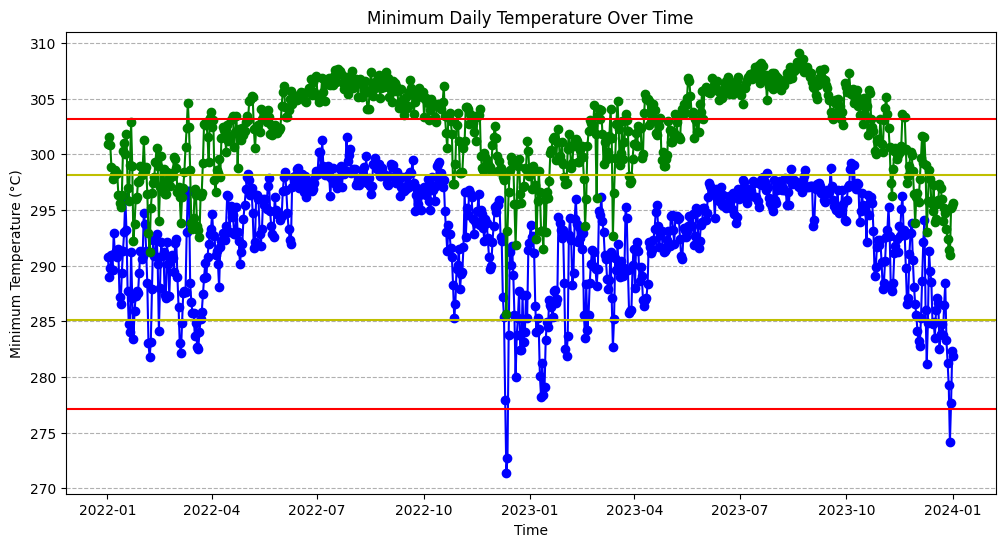

In [119]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


# ... (Assuming you have your 'tasmin' DataArray loaded)

# Extract time values (if not already a datetime index)
ltime_values = loca_tasmin.isel(lat=lat,lon=lon).time.values
ltemp_values = loca_tasmin.isel(lat=lat,lon=lon).values

utime_values = loca_tasmax.isel(lat=lat,lon=lon).time.values
utemp_values = loca_tasmax.isel(lat=lat,lon=lon).values

# print(temp_values)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(ltime_values, ltemp_values, marker='o', linestyle='-', color='blue')
plt.plot(utime_values, utemp_values, marker='o', linestyle='-', color='green')
plt.axhline(y = tmin + 273.15, color = 'r', linestyle = '-') 
plt.axhline(y = tmax + 273.15, color = 'r', linestyle = '-') 
plt.axhline(y = topt_min + 273.15, color = 'y', linestyle = '-') 
plt.axhline(y = topt_max + 273.15, color = 'y', linestyle = '-')

ax = plt.gca()

for dates in optimal_planting_ranges[105]:
    [d1,d2] = dates
    ax.add_patch(Rectangle((d1, 270), d2-d1, 310-270))


# Add labels and title
plt.title('Minimum Daily Temperature Over Time')
plt.xlabel('Time')
plt.ylabel('Minimum Temperature (°C)')  # Assuming tasmin is in Celsius; change if necessary
plt.grid(axis='y', linestyle='--')

# Show the plot
plt.show()


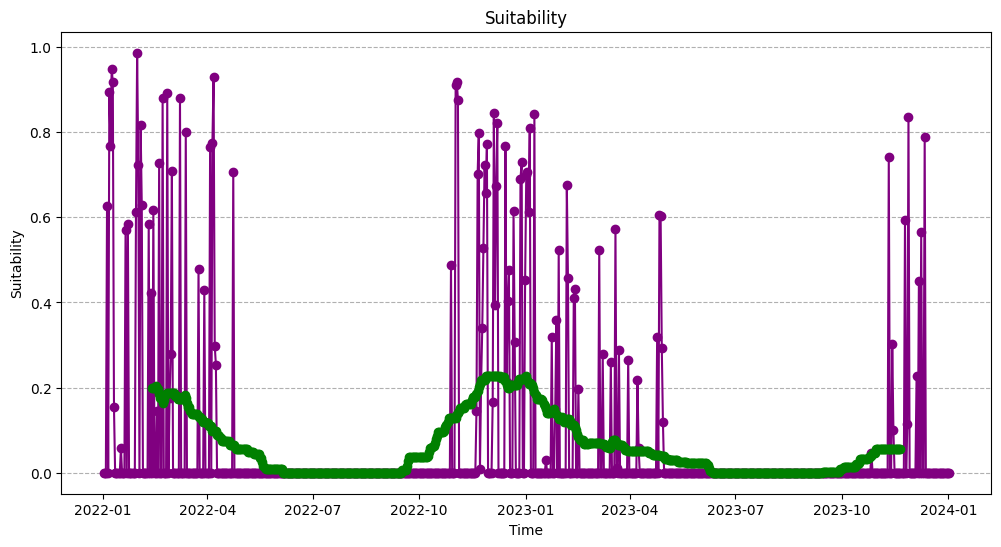

In [120]:
n_repeats = 2

# time_span = daily_suitability.time[-1] - daily_suitability.time[0]
# new_times = [daily_suitability.time + i * time_span for i in range(n_repeats)]
# new_times = xr.concat(new_times, dim="time")
# Get the time span of the original data
# time_span = daily_suitability.time[-1] - daily_suitability.time[0]

# # Create a new time array by *subtracting* multiples of the time span from the original time coordinates
# new_times = [daily_suitability.time - i * time_span for i in range(1, n_repeats + 1)][::-1] # Reverse the list 
# new_times = xr.concat(new_times, dim="time")

# daily_suitability_extended = xr.DataArray(
#     data=np.tile(daily_suitability.values, (n_repeats, 1, 1)),  # Tile the values along the time axis
#     coords={"time": new_times, "lat": daily_suitability.lat, "lon": daily_suitability.lon},  # Use new time coordinates
#     dims=["time", "lat", "lon"],
# )
window_size = 85
plt.figure(figsize=(12, 6))
plt.plot(daily_suitability.isel(lat=lat,lon=lon).time.values, daily_suitability.isel(lat=lat,lon=lon), marker='o', linestyle='-', color='purple')
# plt.plot(daily_suitability.isel(lat=lat,lon=lon).time.values, daily_suitability.isel(lat=lat,lon=lon), marker='o', linestyle='-', color='purple')
# plt.plot(growing_season_suitability[105].isel(lat=lat,lon=lon).time.values, growing_season_suitability[105].isel(lat=lat,lon=lon), marker='o', linestyle='-', color='purple')
plt.plot(growing_season_suitability[window_size].isel(lat=lat,lon=lon).time.values, growing_season_suitability[window_size].isel(lat=lat,lon=lon), marker='o', linestyle='-', color='green')
# Add labels and title
plt.title('Suitability')
plt.xlabel('Time')
plt.ylabel('Suitability')  # Assuming tasmin is in Celsius; change if necessary
plt.grid(axis='y', linestyle='--')

# Show the plot
plt.show()